# Import Dependencies

In [7]:
import sys
sys.path.append('..')
import dependencies
import soft_dependencies
import matplotlib.pyplot as plt

Python Version 3.9.12 (main, Jun  1 2022, 06:36:29) 
[Clang 12.0.0 ]
Numpy Version 1.22.2
Scipy Version 1.7.3
Sklearn Version 1.0.2
Matplotlib Version 3.5.1
Pandas Version 1.4.2
Line Profiler Version 3.3.1
Memory Profiler Version 0.58.0


In [67]:
from Scripts.generate_data import generate_Ys
from Scripts.scBiGLasso import scBiGLasso
from Scripts.anBiGLasso import anBiGLasso
from Scripts.EiGLasso import EiGLasso
from Scripts.TeraLasso import TeraLasso

In [77]:
# For timing results
import timeit

# For colorblind palette creation
from cycler import cycler

In [10]:
%load_ext autoreload
%autoreload 2

# Time scBiGLasso and anBiGLasso
**Note:**

'Easy' data comes from precision matrices generated from an
inverse Wishart distribution with many degrees of freedom.
Empirically, scBiGLasso converges very quickly.

'Hard' data comes from precision amtrices generated from an
inverse Wishart distribution with minimal degrees of freedom.
Empirically, scBiGLasso takes a long time to converge.

In [7]:
def generate_timing_graph(
    sizes,
    attempts, 
    m,
    df_scale,
    include_sc=True,
    include_eig=True,
    verbose=False
):
    if include_sc:
        times_sc = []
    times_an = []
    if include_eig:
        times_eig = []
    for size in sizes:
        if verbose:
            print(f"Starting {size=}")
        if include_sc:
            times_sc.append(0)
        times_an.append(0)
        if include_eig:
            times_eig.append(0)
        _, _, Ys = generate_Ys(
            m=m,
            n=(n:=size),
            p=(p:=size),
            expected_nonzero_psi=n**2 / 5,
            expected_nonzero_theta=p**2 / 5,
            structure="Kronecker Sum",
            df_scale=df_scale
        )
        def time_scBiGLasso():
            scBiGLasso(
                N = 100,
                eps = 10e-4,
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01,
                verbose = False
            )
        def time_anBiGLasso():
            anBiGLasso(
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01,
                B_approx_iters = 10
            )
        def time_EiGLasso():
            EiGLasso(
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01
            )
        if include_sc:
            timer = timeit.Timer(time_scBiGLasso)
            times_sc[-1] = timer.timeit(attempts) / attempts
        timer = timeit.Timer(time_anBiGLasso)
        times_an[-1] = timer.timeit(attempts) / attempts
        if include_eig:
            timer = timeit.Timer(time_EiGLasso)
            times_eig[-1] = timer.timeit(attempts) / attempts
        if verbose:
            if include_sc:
                print(
                    f"\tSc : {times_sc[-1]} Seconds"
                    + f"\n\tAn : {times_an[-1]} Seconds"
                    + (f"\n\tEig: {times_eig[-1]} Seconds" if include_eig else "")
                )
            else:
                print(
                    f"\tAn : {times_an[-1]} Seconds"
                    + (f"\n\tEig: {times_eig[-1]} Seconds" if include_eig else "")
                )
    if include_sc and include_eig:
        return times_sc, times_an, times_eig
    elif include_sc:
        return times_sc, times_an
    elif include_eig:
        return times_an, times_eig
    else:
        return times_an

### Large Sample

In [16]:
attempts = 10
print("Times on an 'easy' distribution")
sizes_for_easy = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
sc_easy, an_easy, eig_easy = generate_timing_graph(
    sizes_for_easy,
    attempts,
    df_scale=10,
    m=100,
    verbose=True
)
print("Times on a 'hard' distribution")
sizes_for_hard = [10, 20, 30, 40, 50]
sc_hard, an_hard, eig_hard = generate_timing_graph(
    sizes_for_hard,
    attempts,
    df_scale=1,
    m=100,
    verbose=True
)

Times on an 'easy' distribution
Starting size=10
	Sc : 0.025689033300022857 Seconds
	An : 0.001062945900048362 Seconds
	Eig: 0.008558258300035959 Seconds
Starting size=20
	Sc : 0.042799695899975634 Seconds
	An : 0.0019620041000052877 Seconds
	Eig: 0.00343000419998134 Seconds
Starting size=30
	Sc : 0.06817909159999544 Seconds
	An : 0.0036453708000408367 Seconds
	Eig: 0.005485591699925863 Seconds
Starting size=40
	Sc : 0.11240949160001037 Seconds
	An : 0.007017808399996284 Seconds
	Eig: 0.009582637499988778 Seconds
Starting size=50
	Sc : 0.14808728329999213 Seconds
	An : 0.010451825000018289 Seconds
	Eig: 0.016570770899943455 Seconds
Starting size=60
	Sc : 0.1997614040999906 Seconds
	An : 0.01537568329995338 Seconds
	Eig: 0.022858274999998686 Seconds
Starting size=70
	Sc : 0.24127513339999496 Seconds
	An : 0.029160787500040898 Seconds
	Eig: 0.03076984999997876 Seconds
Starting size=80
	Sc : 0.314731912499974 Seconds
	An : 0.036802370900022655 Seconds
	Eig: 0.040576241700000536 Seconds
St

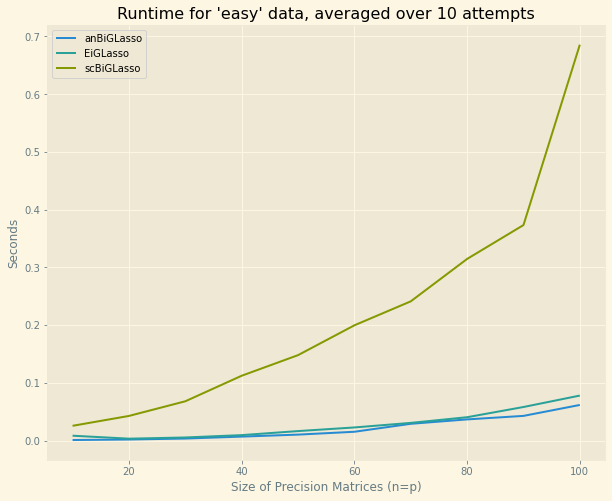

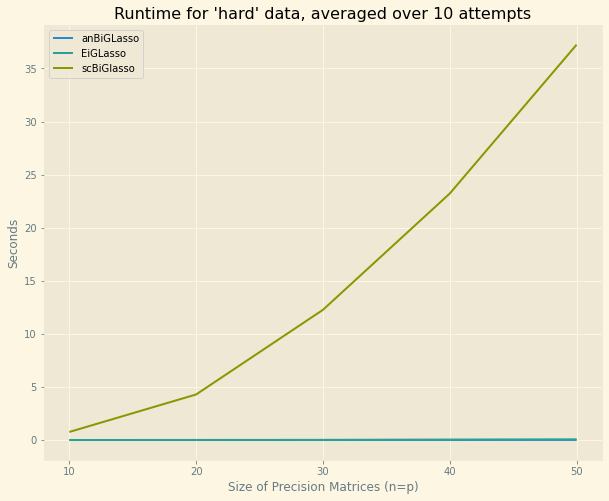

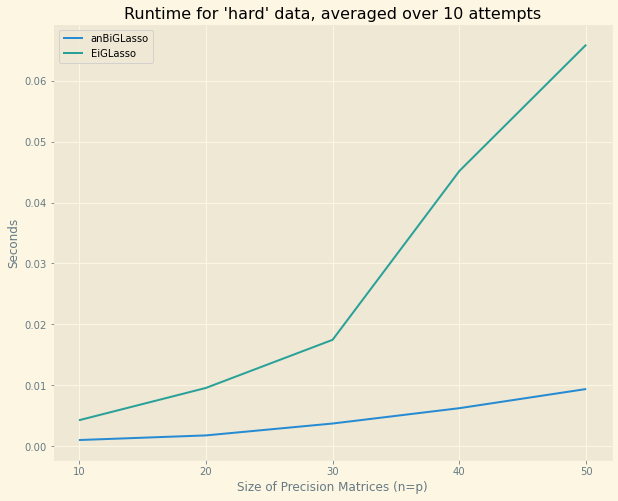

In [17]:
with plt.style.context('Solarize_Light2'):
        fig1, ax1 = plt.subplots(figsize=(10, 8))
        ax1.plot(sizes_for_easy, an_easy, label='anBiGLasso')
        ax1.plot(sizes_for_easy, eig_easy, label='EiGLasso')
        ax1.plot(sizes_for_easy, sc_easy, label='scBiGLasso')
        ax1.set_xlabel("Size of Precision Matrices (n=p)")
        ax1.set_ylabel("Seconds")
        ax1.set_title(f"Runtime for 'easy' data, averaged over {attempts} attempts")
        ax1.legend()
        fig1.savefig(f'../../Plots/Runtimes Comparison/Compare Runtimes Easy Data Large Sample')
        fig2, ax2 = plt.subplots(figsize=(10, 8))
        ax2.plot(sizes_for_hard, an_hard, label='anBiGLasso')
        ax2.plot(sizes_for_hard, eig_hard, label='EiGLasso')
        ax2.plot(sizes_for_hard, sc_hard, label='scBiGlasso')
        ax2.set_xlabel("Size of Precision Matrices (n=p)")
        ax2.set_ylabel("Seconds")
        ax2.set_xticks([10, 20, 30, 40, 50])
        ax2.set_title(f"Runtime for 'hard' data, averaged over {attempts} attempts")
        ax2.legend()
        fig2.savefig(f'../../Plots/Runtimes Comparison/Compare Runtimes Hard Data Large Sample')
        fig3, ax3 = plt.subplots(figsize=(10, 8))
        ax3.plot(sizes_for_hard, an_hard, label='anBiGLasso')
        ax3.plot(sizes_for_hard, eig_hard, label='EiGLasso')
        ax3.set_xlabel("Size of Precision Matrices (n=p)")
        ax3.set_ylabel("Seconds")
        ax3.set_xticks([10, 20, 30, 40, 50])
        ax3.set_title(f"Runtime for 'hard' data, averaged over {attempts} attempts")
        ax3.legend()
        fig3.savefig(
            f'../../Plots/Runtimes Comparison/Compare Runtimes Hard Data No scBiGLasso Large Sample'
        )

### Small Sample

In [10]:
print("Times on an 'easy' distribution")
sizes_for_easy = [10, 20, 30, 40, 50]
sc_easy, an_easy, eig_easy = generate_timing_graph(
    sizes_for_easy,
    attempts,
    df_scale=10,
    m=1,
    verbose=True
)
print("Times on a 'hard' distribution")
sizes_for_hard = [10, 20, 30, 40, 50]
sc_hard, an_hard, eig_hard = generate_timing_graph(
    sizes_for_hard,
    attempts,
    df_scale=1,
    m=1,
    verbose=True
)

Times on an 'easy' distribution
Starting size=10
	Sc : 1.5637737749999814 Seconds
	An : 0.0010289208000358486 Seconds
	Eig: 0.01093206669997926 Seconds
Starting size=20
	Sc : 15.327966591699987 Seconds
	An : 0.0019276375000117697 Seconds
	Eig: 0.02462910419999389 Seconds
Starting size=30
	Sc : 15.987220549999984 Seconds
	An : 0.037519162499984306 Seconds
	Eig: 0.06454114590001155 Seconds
Starting size=40
	Sc : 32.795254287499986 Seconds
	An : 0.003429362499991839 Seconds
	Eig: 0.12917245420003381 Seconds
Starting size=50
	Sc : 38.14393277920003 Seconds
	An : 0.005438541600051394 Seconds
	Eig: 0.17250978749998466 Seconds
Times on a 'hard' distribution
Starting size=10
	Sc : 0.6410062083999947 Seconds
	An : 0.0010276459000124305 Seconds
	Eig: 0.05397009590005837 Seconds
Starting size=20
	Sc : 2.739221658399947 Seconds
	An : 0.0019677999999657913 Seconds
	Eig: 0.2397458125000412 Seconds
Starting size=30
	Sc : 6.497756287500033 Seconds
	An : 0.0023629708000044046 Seconds
	Eig: 0.6951139290

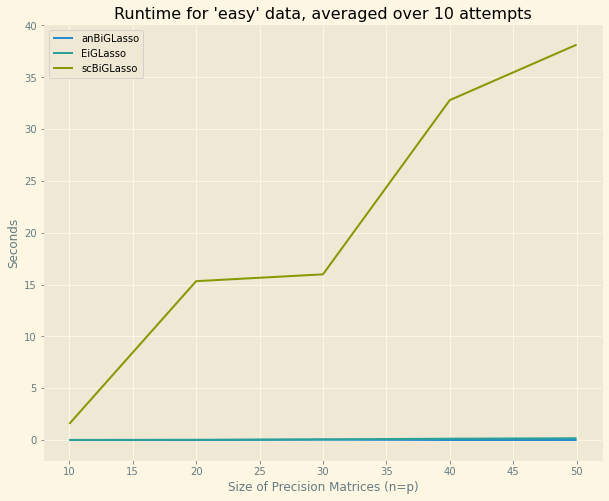

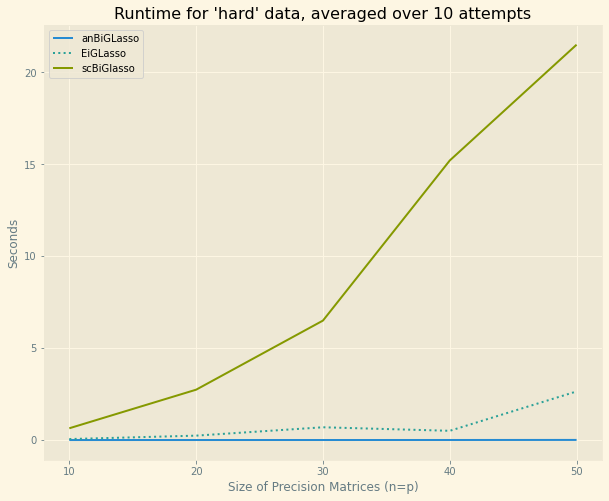

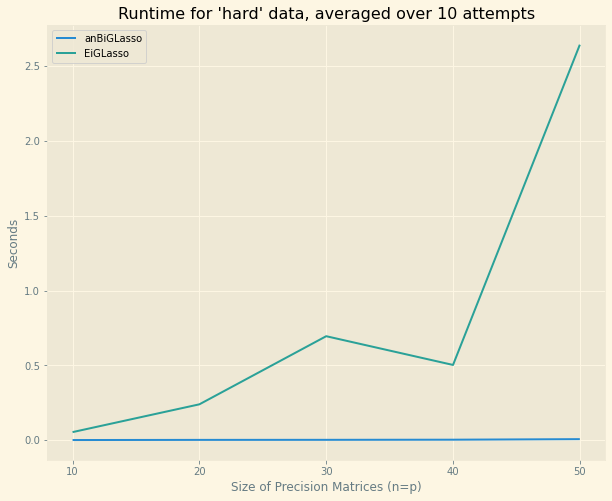

In [11]:
with plt.style.context('Solarize_Light2'):
        fig1, ax1 = plt.subplots(figsize=(10, 8))
        ax1.plot(sizes_for_easy, an_easy, label='anBiGLasso')
        ax1.plot(sizes_for_easy, eig_easy, label='EiGLasso')
        ax1.plot(sizes_for_easy, sc_easy, label='scBiGLasso')
        ax1.set_xlabel("Size of Precision Matrices (n=p)")
        ax1.set_ylabel("Seconds")
        ax1.set_title(f"Runtime for 'easy' data, averaged over {attempts} attempts")
        ax1.legend()
        fig1.savefig(f'../../Plots/Runtimes Comparison/Compare Runtimes Easy Data Small Sample')
        fig2, ax2 = plt.subplots(figsize=(10, 8))
        ax2.plot(sizes_for_hard, an_hard, label='anBiGLasso')
        ax2.plot(sizes_for_hard, eig_hard, label='EiGLasso')
        ax2.plot(sizes_for_hard, sc_hard, label='scBiGlasso')
        ax2.set_xlabel("Size of Precision Matrices (n=p)")
        ax2.set_ylabel("Seconds")
        ax2.set_xticks([10, 20, 30, 40, 50])
        ax2.set_title(f"Runtime for 'hard' data, averaged over {attempts} attempts")
        ax2.legend()
        fig2.savefig(f'../../Plots/Runtimes Comparison/Compare Runtimes Hard Data Small Sample')
        fig3, ax3 = plt.subplots(figsize=(10, 8))
        ax3.plot(sizes_for_hard, an_hard, label='anBiGLasso')
        ax3.plot(sizes_for_hard, eig_hard, label='EiGLasso')
        ax3.set_xlabel("Size of Precision Matrices (n=p)")
        ax3.set_ylabel("Seconds")
        ax3.set_xticks([10, 20, 30, 40, 50])
        ax3.set_title(f"Runtime for 'hard' data, averaged over {attempts} attempts")
        ax3.legend()
        fig3.savefig(
            f'../../Plots/Runtimes Comparison/Compare Runtimes Hard Data No scBiGLasso Small Sample'
        )

### Small Sample, just an and eig

In [12]:
attempts = 10
print("Times on an 'easy' distribution")
sizes_for_easy = [50, 100, 150, 200, 250, 300]
an_easy, eig_easy = generate_timing_graph(
    sizes_for_easy,
    attempts,
    df_scale=10,
    m=1,
    verbose=True,
    include_sc=False
)
print("Times on a 'hard' distribution")
sizes_for_hard = [50, 100, 150, 200, 250, 300]
an_hard, eig_hard = generate_timing_graph(
    sizes_for_hard,
    attempts,
    df_scale=1,
    m=1,
    verbose=True,
    include_sc=False
)

Times on an 'easy' distribution
Starting size=50
	An : 0.007248370799970871 Seconds
	Eig: 0.17567044999996143 Seconds
Starting size=100
	An : 0.02143512919992645 Seconds
	Eig: 0.7391165417000594 Seconds
Starting size=150
	An : 0.03504637500000172 Seconds
	Eig: 2.0566682458000285 Seconds
Starting size=200
	An : 0.048259891699945004 Seconds
	Eig: 4.007336945899988 Seconds
Starting size=250
	An : 0.07487656250004875 Seconds
	Eig: 8.19794692080004 Seconds
Starting size=300
	An : 0.09848439999996117 Seconds
	Eig: 12.843715075 Seconds
Times on a 'hard' distribution
Starting size=50
	An : 0.008451520899961906 Seconds
	Eig: 5.568464370899983 Seconds
Starting size=100
	An : 0.026191437499983296 Seconds
	Eig: 19.80666364580002 Seconds
Starting size=150
	An : 0.03610687919999691 Seconds
	Eig: 11.592113604199948 Seconds
Starting size=200
	An : 0.05602634159995432 Seconds
	Eig: 23.048807170800046 Seconds
Starting size=250
	An : 0.07719190840007287 Seconds
	Eig: 29.435861616700002 Seconds
Starting s

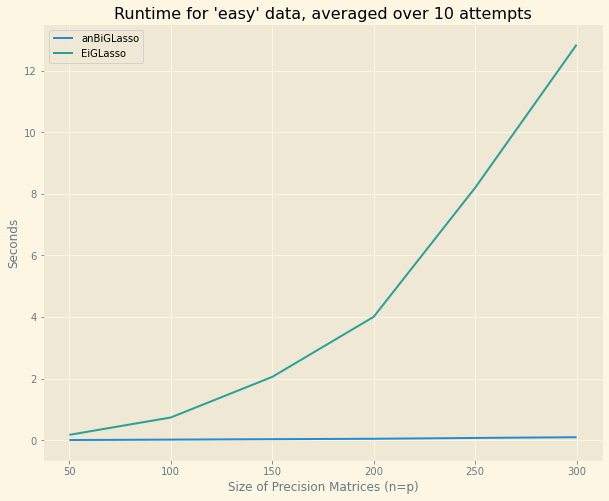

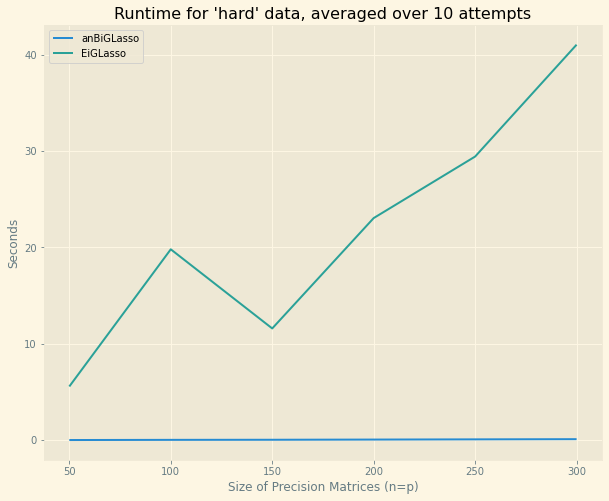

In [13]:
with plt.style.context('Solarize_Light2'):
        fig1, ax1 = plt.subplots(figsize=(10, 8))
        ax1.plot(sizes_for_easy, an_easy, label='anBiGLasso')
        ax1.plot(sizes_for_easy, eig_easy, label='EiGLasso')
        ax1.set_xlabel("Size of Precision Matrices (n=p)")
        ax1.set_ylabel("Seconds")
        ax1.set_title(f"Runtime for 'easy' data, averaged over {attempts} attempts")
        ax1.legend()
        fig1.savefig(f'../../Plots/Runtimes Comparison/Compare Runtimes Easy Data Small Sample No sc')
        fig2, ax2 = plt.subplots(figsize=(10, 8))
        ax2.plot(sizes_for_hard, an_hard, label='anBiGLasso')
        ax2.plot(sizes_for_hard, eig_hard, label='EiGLasso')
        ax2.set_xlabel("Size of Precision Matrices (n=p)")
        ax2.set_ylabel("Seconds")
        ax2.set_title(f"Runtime for 'hard' data, averaged over {attempts} attempts")
        ax2.legend()
        fig2.savefig(f'../../Plots/Runtimes Comparison/Compare Runtimes Hard Data Small Sample No sc')

# Just anBiGLasso, very large data

In [14]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a 'hard' distribution")
sizes_for_hard = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
an_hard = generate_timing_graph(
    sizes_for_hard,
    attempts,
    df_scale=1,
    m=1,
    verbose=True,
    include_sc=False,
    include_eig=False
)

Times on a 'hard' distribution
Starting size=500
	An : 0.2790525840000555 Seconds
Starting size=1000
	An : 1.1452061660002073 Seconds
Starting size=1500
	An : 2.836115250000148 Seconds
Starting size=2000
	An : 5.657763375000286 Seconds
Starting size=2500
	An : 9.78704737499993 Seconds
Starting size=3000
	An : 15.442992834000506 Seconds
Starting size=3500
	An : 23.88409941700047 Seconds
Starting size=4000
	An : 33.98595424999985 Seconds
Starting size=4500
	An : 47.45029629200053 Seconds
Starting size=5000
	An : 62.716043291999995 Seconds


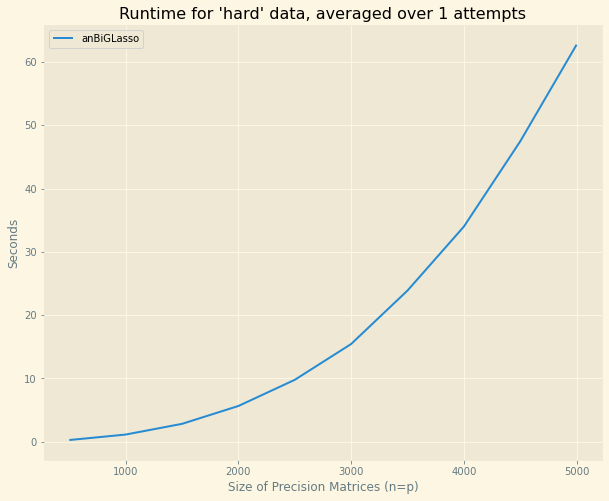

In [15]:
with plt.style.context('Solarize_Light2'):
        fig1, ax1 = plt.subplots(figsize=(10, 8))
        ax1.plot(sizes_for_hard, an_hard, label='anBiGLasso')
        ax1.set_xlabel("Size of Precision Matrices (n=p)")
        ax1.set_ylabel("Seconds")
        ax1.set_title(f"Runtime for 'hard' data, averaged over {attempts} attempts")
        ax1.legend()
        fig1.savefig(
            f'../../Plots/Runtimes Comparison/Compare Runtimes Small Sample Just anBiGLasso'
        )

# All Together

In [68]:
def generate_timing_graph_smart(
    sizes,
    attempts, 
    m,
    df_scale,
    cutoff: "Amount of seconds before we stop considering it"=60,
    verbose=False
):
    include_sc = True
    include_eig = True
    include_an = True
    include_tera = True
    times_sc = []
    times_eig = []
    times_an = []
    times_tera = []
    for size in sizes:
        if not include_sc and not include_eig and not include_tera:
            # No need to do multiple attempts for
            # the non-iterative anBiGLasso algorithm
            attempts=1
        if verbose:
            print(f"Starting {size=}")
        if include_sc:
            times_sc.append(0)
        if include_an:
            times_an.append(0)
        if include_eig:
            times_eig.append(0)
        if include_tera:
            times_tera.append(0)
        _, _, Ys = generate_Ys(
            m=m,
            n=(n:=size),
            p=(p:=size),
            expected_nonzero_psi=n**2 / 5,
            expected_nonzero_theta=p**2 / 5,
            structure="Kronecker Sum",
            df_scale=df_scale
        )
        def time_scBiGLasso():
            scBiGLasso(
                N = 100,
                eps = 10e-4,
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01,
                verbose = False
            )
        def time_anBiGLasso():
            anBiGLasso(
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01,
                B_approx_iters = 10
            )
        def time_EiGLasso():
            EiGLasso(
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01
            )
        def time_TeraLasso():
            TeraLasso(
                Ys,
                np.array(
                    [0.01, 0.01],
                    dtype=np.float64
                )
            )
        if include_sc:
            timer = timeit.Timer(time_scBiGLasso)
            times_sc[-1] = timer.timeit(attempts) / attempts
            if times_sc[-1] >= cutoff:
                include_sc = False
        if include_an:
            timer = timeit.Timer(time_anBiGLasso)
            times_an[-1] = timer.timeit(attempts) / attempts
            if times_an[-1] >= cutoff:
                include_an = False
        if include_eig:
            timer = timeit.Timer(time_EiGLasso)
            times_eig[-1] = timer.timeit(attempts) / attempts
            if times_eig[-1] >= cutoff:
                include_eig = False
        if include_tera:
            timer = timeit.Timer(time_TeraLasso)
            times_tera[-1] = timer.timeit(attempts) / attempts
            if times_tera[-1] >= cutoff:
                include_tera = False
        if verbose:
            print(
                (f"\n\tSc : {times_sc[-1]} Seconds" if include_sc else "")
                + (f"\n\tAn: {times_an[-1]} Seconds" if include_an else "")
                + (f"\n\tEig : {times_eig[-1]} Seconds" if include_eig else "")
                + (f"\n\tTera : {times_tera[-1]} Seconds" if include_tera else "")
            )
    return times_sc, times_an, times_eig, times_tera

In [69]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a small-sample 'hard' distribution")
sizes_for_hard_small = [
    20, 40, 60, 80, 100,
    125, 150, 175, 200,
    250, 300, 350, 400, 450, 500,
    600, 700, 800, 900, 1000,
    1250, 1500, 1750, 2000,
    2500, 3000, 3500, 4000,
    4500, 5000, 5500, 6000
]
sc_hard_small, an_hard_small, eig_hard_small, tera_hard_small = generate_timing_graph_smart(
    sizes_for_hard_small,
    attempts,
    df_scale=1,
    m=1,
    cutoff=60,
    verbose=True
)

Times on a small-sample 'hard' distribution
Starting size=20

	Sc : 2.347747082996648 Seconds
	An: 0.0018752080504782498 Seconds
	Eig : 0.21147350000683218 Seconds
	Tera : 2.432229583035223 Seconds
Starting size=40

	Sc : 13.178709666011855 Seconds
	An: 0.003625167009886354 Seconds
	Eig : 1.212890958006028 Seconds
	Tera : 7.366343249974307 Seconds
Starting size=60

	Sc : 35.87378695799271 Seconds
	An: 0.007747167022898793 Seconds
	Eig : 3.2546082079643384 Seconds
	Tera : 8.913411709014326 Seconds
Starting size=80

	An: 0.009695083019323647 Seconds
	Eig : 4.310053291032091 Seconds
	Tera : 10.50778841698775 Seconds
Starting size=100

	An: 0.02738891600165516 Seconds
	Eig : 5.14915904100053 Seconds
	Tera : 14.596416207961738 Seconds
Starting size=125

	An: 0.03321291599422693 Seconds
	Eig : 8.915622290980536 Seconds
	Tera : 17.93707624997478 Seconds
Starting size=150

	An: 0.042077707999851555 Seconds
	Eig : 15.25970504101133 Seconds
	Tera : 2.681499416998122 Seconds
Starting size=175

	A

In [70]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a small-sample 'easy' distribution")
sizes_for_easy_small = [
    20, 40, 60, 80, 100,
    125, 150, 175, 200,
    250, 300, 350, 400, 450, 500,
    600, 700, 800, 900, 1000,
    1250, 1500, 1750, 2000,
    2500, 3000, 3500, 4000,
    4500, 5000, 5500, 6000
]
sc_easy_small, an_easy_small, eig_easy_small, tera_easy_small = generate_timing_graph_smart(
    sizes_for_easy_small,
    attempts,
    df_scale=2,
    m=1,
    cutoff=60,
    verbose=True
)

Times on a small-sample 'easy' distribution
Starting size=20

	Sc : 5.815011166036129 Seconds
	An: 0.0015464999596588314 Seconds
	Eig : 0.04402750002918765 Seconds
	Tera : 0.4524755830061622 Seconds
Starting size=40

	Sc : 23.66527125000721 Seconds
	An: 0.0030834589852020144 Seconds
	Eig : 0.11063249997096136 Seconds
	Tera : 3.2173384579946287 Seconds
Starting size=60

	An: 0.00711812503868714 Seconds
	Eig : 0.29200112499529496 Seconds
	Tera : 1.5451979999779724 Seconds
Starting size=80

	An: 0.015857208985835314 Seconds
	Eig : 0.5340196659672074 Seconds
	Tera : 5.85311304096831 Seconds
Starting size=100

	An: 0.025806833989918232 Seconds
	Eig : 0.8789059579721652 Seconds
	Tera : 1.6399640829768032 Seconds
Starting size=125

	An: 0.03925283398712054 Seconds
	Eig : 1.575307207996957 Seconds
	Tera : 18.238998666987754 Seconds
Starting size=150

	An: 0.03639300004579127 Seconds
	Eig : 2.270646334043704 Seconds
	Tera : 4.3012409579823725 Seconds
Starting size=175

	An: 0.058233208023011684

In [71]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a large-sample 'hard' distribution")
sizes_for_hard_large = [
    20, 40, 60, 80, 100,
    125, 150, 175, 200,
    250, 300, 350, 400, 450, 500
]
sc_hard_large, an_hard_large, eig_hard_large, tera_hard_large = generate_timing_graph_smart(
    sizes_for_hard_large,
    attempts,
    df_scale=1,
    m=100,
    cutoff=60,
    verbose=True
)

Times on a large-sample 'hard' distribution
Starting size=20

	Sc : 4.764745542022865 Seconds
	An: 0.00249129201984033 Seconds
	Eig : 0.025516249996144325 Seconds
	Tera : 0.3609421669971198 Seconds
Starting size=40

	Sc : 22.394036957994103 Seconds
	An: 0.010381040978245437 Seconds
	Eig : 0.056128625001292676 Seconds
	Tera : 0.45572587504284456 Seconds
Starting size=60

	An: 0.016498540993779898 Seconds
	Eig : 0.1020782080013305 Seconds
	Tera : 8.663917125028092 Seconds
Starting size=80

	An: 0.06000662496080622 Seconds
	Eig : 0.1972701660124585 Seconds
	Tera : 1.1725572500145063 Seconds
Starting size=100

	An: 0.10246700001880527 Seconds
	Eig : 0.34235291596269235 Seconds
	Tera : 1.533952334022615 Seconds
Starting size=125

	An: 0.11250983399804682 Seconds
	Eig : 0.485398874967359 Seconds
	Tera : 19.81992524996167 Seconds
Starting size=150

	An: 0.12426370900357142 Seconds
	Eig : 0.6889881670358591 Seconds
	Tera : 34.02941170800477 Seconds
Starting size=175

	An: 0.15656249999301508 S

In [72]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a large-sample 'easy' distribution")
sizes_for_easy_large = [
    20, 40, 60, 80, 100,
    125, 150, 175, 200,
    250, 300, 350, 400, 450, 500
]
sc_easy_large, an_easy_large, eig_easy_large, tera_easy_large = generate_timing_graph_smart(
    sizes_for_easy_large,
    attempts,
    df_scale=2,
    m=100,
    cutoff=60,
    verbose=True
)

Times on a large-sample 'easy' distribution
Starting size=20

	Sc : 0.08337583299726248 Seconds
	An: 0.002522166003473103 Seconds
	Eig : 0.0049142499919980764 Seconds
	Tera : 0.11697612499119714 Seconds
Starting size=40

	Sc : 0.20871220802655444 Seconds
	An: 0.006216333014890552 Seconds
	Eig : 0.03627020900603384 Seconds
	Tera : 0.5148824999923818 Seconds
Starting size=60

	Sc : 0.42884695797692984 Seconds
	An: 0.014993791992310435 Seconds
	Eig : 0.030112542037386447 Seconds
	Tera : 1.170636291964911 Seconds
Starting size=80

	Sc : 1.2958223749883473 Seconds
	An: 0.05559099995298311 Seconds
	Eig : 0.05807691701920703 Seconds
	Tera : 2.3220122500206344 Seconds
Starting size=100

	Sc : 4.964183999982197 Seconds
	An: 0.1396220829919912 Seconds
	Eig : 0.23557445796905085 Seconds
	Tera : 6.704114291002043 Seconds
Starting size=125

	Sc : 5.071838208008558 Seconds
	An: 0.21505833399714902 Seconds
	Eig : 0.30036216700682417 Seconds
	Tera : 6.708924416976515 Seconds
Starting size=150

	Sc : 3

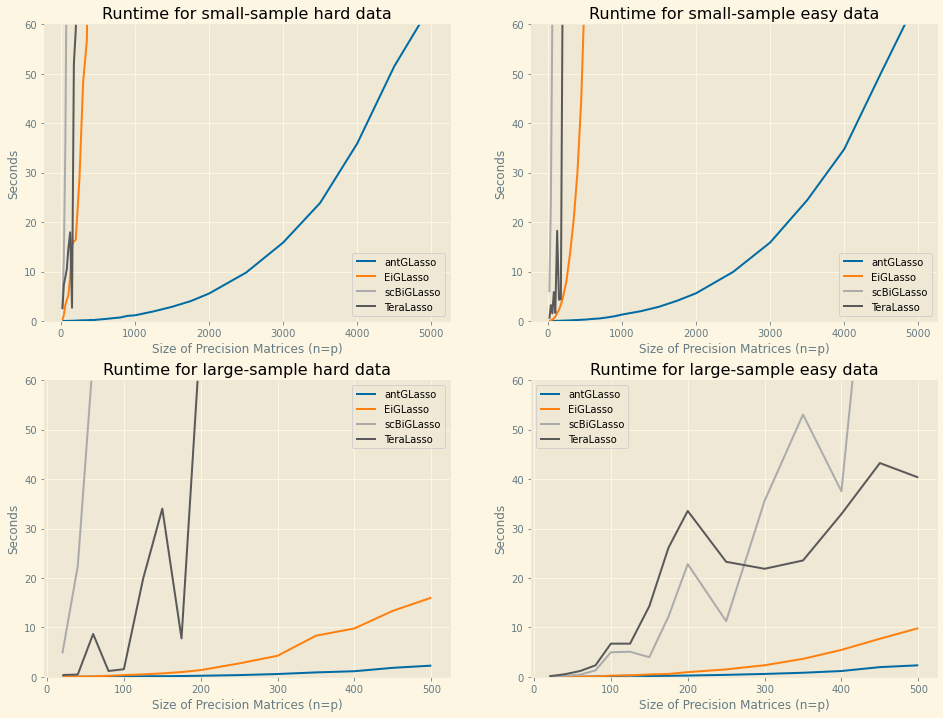

In [78]:
with plt.style.context('Solarize_Light2'):
        plt.rcParams['axes.prop_cycle'] = cycler(color=[
            '#006BA4',
            '#FF800E',
            '#ABABAB',
            '#595959',
            '#5F9ED1',
            '#C85200',
            '#898989',
            '#A2C8EC',
            '#FFBC79',
            '#CFCFCF'
        ])
        fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(16, 12), nrows=2, ncols=2)
        ax1.plot(
            sizes_for_hard_small[:len(an_hard_small)],
            an_hard_small,
            label='antGLasso'
        )
        ax1.plot(
            sizes_for_hard_small[:len(eig_hard_small)],
            eig_hard_small,
            label='EiGLasso'
        )
        ax1.plot(sizes_for_hard_small[:len(sc_hard_small)],
                 sc_hard_small,
                 label='scBiGLasso'
        )
        ax1.plot(sizes_for_hard_small[:len(tera_hard_small)],
                 tera_hard_small,
                 label='TeraLasso'
        )
        ax1.set_xlabel("Size of Precision Matrices (n=p)")
        ax1.set_ylabel("Seconds")
        ax1.set_title(f"Runtime for small-sample hard data")
        ax1.set_ylim([0, 60])
        ax1.legend()
        
        ax2.plot(
            sizes_for_easy_small[:len(an_easy_small)],
            an_easy_small,
            label='antGLasso'
        )
        ax2.plot(
            sizes_for_easy_small[:len(eig_easy_small)],
            eig_easy_small,
            label='EiGLasso'
        )
        ax2.plot(sizes_for_easy_small[:len(sc_easy_small)],
                 sc_easy_small,
                 label='scBiGLasso'
        )
        ax2.plot(sizes_for_easy_small[:len(tera_easy_small)],
                 tera_easy_small,
                 label='TeraLasso'
        )
        ax2.set_xlabel("Size of Precision Matrices (n=p)")
        ax2.set_ylabel("Seconds")
        ax2.set_title(f"Runtime for small-sample easy data")
        ax2.set_ylim([0, 60])
        ax2.legend()
        
        ax3.plot(
            sizes_for_hard_large[:len(an_hard_large)],
            an_hard_large,
            label='antGLasso'
        )
        ax3.plot(
            sizes_for_hard_large[:len(eig_hard_large)],
            eig_hard_large,
            label='EiGLasso'
        )
        ax3.plot(sizes_for_hard_large[:len(sc_hard_large)],
                 sc_hard_large,
                 label='scBiGLasso'
        )
        ax3.plot(sizes_for_hard_large[:len(tera_hard_large)],
                 tera_hard_large,
                 label='TeraLasso'
        )
        ax3.set_xlabel("Size of Precision Matrices (n=p)")
        ax3.set_ylabel("Seconds")
        ax3.set_title(f"Runtime for large-sample hard data")
        ax3.set_ylim([0, 60])
        ax3.legend()
        
        ax4.plot(
            sizes_for_easy_large[:len(an_easy_large)],
            an_easy_large,
            label='antGLasso'
        )
        ax4.plot(
            sizes_for_easy_large[:len(eig_easy_large)],
            eig_easy_large,
            label='EiGLasso'
        )
        ax4.plot(sizes_for_easy_large[:len(sc_easy_large)],
                 sc_easy_large,
                 label='scBiGLasso'
        )
        ax4.plot(sizes_for_easy_large[:len(tera_easy_large)],
                 tera_easy_large,
                 label='TeraLasso'
        )
        ax4.set_xlabel("Size of Precision Matrices (n=p)")
        ax4.set_ylabel("Seconds")
        ax4.set_title(f"Runtime for large-sample easy data")
        ax4.set_ylim([0, 60])
        ax4.legend()
        
        fig1.savefig(f'../../Plots/Runtimes Comparison/All Together')